In [53]:
import numpy as np
import scipy as sp

from matplotlib import pyplot as plt
%matplotlib inline

from IPython.display import HTML, display
display(HTML("<style>.container { width:95% !important; }</style>"))

In [2]:
# Define all the functions needed for mapping from parameters to the data space included defining the Q
#
# Some common inputs:
#   Obs_vec = np.array([o_1,o_2, $\ldots$, o_P])
#   Obs_err_std = standard deviation of observation error
#   S = number of repeated observations
#   lam_true = true parameter value
#   Data_vec = np.array([d_1, d_2, $\ldots$, d_S])

def Q_map(Obs_vec, Obs_err_std, S):
    return np.sqrt(S)/Obs_err_std * Obs_vec

def Noisy_data(lam_true, Obs_vec, Obs_err_std, S):
    return np.random.normal(size=(S,1))*Obs_err_std + np.dot(Obs_vec.transpose(), lam_true)

def b_repeated_obs(Data_vec, Obs_err_std, S):
    return -1/(np.sqrt(S)*Obs_err_std) * np.sum(Data_vec) #needs to be negative!!!! 

In [125]:
#Setup all things about the observation and map

Obs_vec = np.array([[2], [1]])

Obs_err_std = 0.25

S = 10

lam_true = np.array([[0.5],[1.5]])

print(np.dot(Obs_vec.transpose(),lam_true))

A = Q_map(Obs_vec, Obs_err_std, S)

Data_vec = Noisy_data(lam_true, Obs_vec, Obs_err_std, S)

b = b_repeated_obs(Data_vec, Obs_err_std, S)

[[2.5]]


In [135]:
# Define the initial uncertainty parameters mu_init and sigma_init for an 
# initially assumed N(mu_init, sigma_init**2) distribution on $\Lambda$.
#
# NOTE: Using sigma_init for STANDARD DEVIATION and NOT covariance

lam_pert = 5*np.array([[-0.2], [-0.2]]) #the perturbation from lam_true used to form an initial guess

mu_init = lam_true + lam_pert #the initial guess at lam_true

sigma_init = np.array([[0.75],[0.75]]) #the diagonal of the init standard deviation

Sigma_init = np.diag(sigma_init.flatten()) #the init standard deviation matrix

PF_cov = np.dot(A.transpose(),np.dot(Sigma_init**2,A)) #the push-forward COVARIANCE

PF_sigma = np.sqrt(PF_cov)

In [136]:
# Define the necessary functions to define the linear problem for determining the MUD point
#
# Some common inputs:

def gamma_vec(A, sigma_init, PF_cov):
    P = np.size(A)
    gamma = np.zeros((P,1))
    for i in range(P):
        gamma[i] = sigma_init[i]**2 * A[i] * (PF_cov-1)
    return gamma

def Alpha_mat(A, gamma, PF_cov):
    P = np.size(A)
    return np.dot(gamma, A.transpose()) + np.eye(P)*PF_cov

def Alpha_inv_SM(A, gamma, PF_cov):
    P = np.size(A)
    return 1/PF_cov*np.eye(P) - np.dot(gamma,A.transpose())/(PF_cov**2+PF_cov*np.dot(gamma.transpose(),A))

def beta_vec(mu_init, sigma_init, A, b, PF_cov):
    P = np.size(A)
    beta = np.zeros((P,1))
    for i in range(P):
        beta[i] = mu_init[i]*PF_cov-A[i]*sigma_init[i]**2*(np.dot(A.transpose(),mu_init)) - A[i]*sigma_init[i]**2*PF_cov*b
    return beta

In [137]:
print(mu_init)
print(A)
print(np.dot(A.transpose(),mu_init))

print(44.72*0.6+22.36*1.6)

[[-0.5]
 [ 0.5]]
[[25.29822128]
 [12.64911064]]
[[-6.32455532]]
62.608000000000004


In [138]:
gamma = gamma_vec(A,sigma_init,PF_cov)
Alpha = Alpha_mat(A, gamma, PF_cov)
print(Alpha)
Alpha_inv = Alpha_inv_SM(A, gamma, PF_cov)
print(Alpha_inv)
beta = beta_vec(mu_init, sigma_init, A, b, PF_cov)
print(beta)

[[162090.  80820.]
 [ 80820.  40860.]]
[[ 0.0004484  -0.00088691]
 [-0.00088691  0.00177877]]
[[195652.30228306]
 [ 98163.65114153]]


In [139]:
lam_MUD = np.dot(Alpha_inv, beta)
print(lam_MUD)
print()
print(np.dot(Obs_vec.transpose(),lam_MUD))
print()
print(np.dot(Obs_vec.transpose(),lam_true))

[[0.66685088]
 [1.08342544]]

[[2.41712719]]

[[2.5]]


In [140]:
def functional(mu_init, sigma_init, A, b, lam, PF_cov):
    return np.linalg.norm((lam-mu_init)/sigma_init)**2 + np.linalg.norm(np.dot(A.transpose(),lam)+b)**2 \
            - np.linalg.norm(np.dot(A.transpose(), lam-mu_init))**2/PF_cov

In [141]:
print(functional(mu_init,sigma_init, A, b, mu_init, PF_cov))
print()
print(functional(mu_init,sigma_init, A, b, lam_true, PF_cov))
print()
print(functional(mu_init,sigma_init, A, b, lam_MUD, PF_cov))
print()
print(functional(mu_init,sigma_init, A, b, lam_MUD+0.00001, PF_cov))

[[1361.54096559]]

[[1.45442001]]

[[0.]]

[[1.44035555e-07]]


In [142]:
Obs_nullspace = sp.linalg.null_space(Obs_vec.T)
print(Obs_nullspace)

[[-0.4472136 ]
 [ 0.89442719]]


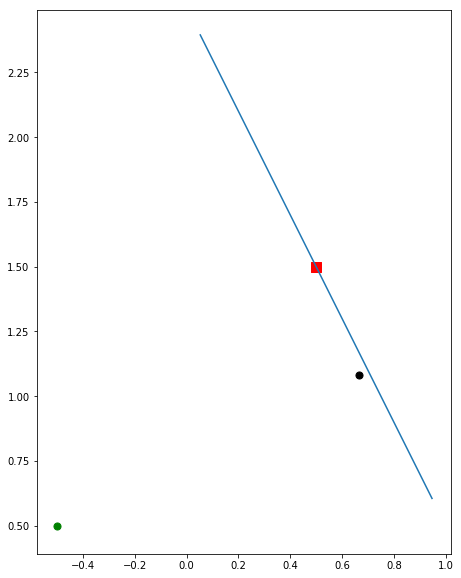

In [143]:
fig, ax = plt.subplots(figsize=(10,10))

s = np.linspace(-1,1,10)
null_line = lam_true + Obs_nullspace*s
plt.plot(null_line[0,:],null_line[1,:])
plt.scatter(lam_true[0],lam_true[1],100,'r',marker='s')
plt.scatter(mu_init[0],mu_init[1],50,'g')
plt.scatter(lam_MUD[0],lam_MUD[1],50,'k')

ax.set_aspect(1.0)